In [1]:
from scipy import signal, integrate
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
from joblib import Parallel, delayed
import mne

from mne.time_frequency import tfr_array_morlet

In [2]:
def get_frequencies():
    return np.array(
        [2.        ,   2.26576777,   2.5668518 ,   2.90794503,
            3.29436407,   3.73213197,   4.22807216,   4.78991482,
            5.42641731,   6.14750073,   6.96440451,   7.88986164,
            8.9382971 ,  10.12605275,  11.47164198,  12.99603834,
            14.72300241,  16.67945217,  18.89588258,  21.40684088,
            24.25146506,  27.47409397,  31.12495832,  35.26096371,
            39.94657756,  45.254834  ,  51.26847217,  58.08122594,
            65.79928491,  74.54294953,  84.44850629,  95.67035191,
            110.        , 130.        , 150.        , 170.        ,
            190.        , 210.        , 230.        , 250.        ,
            270.        , 290.        , 310.        , 330.        ,
            350.        , 370.        , 390.        , 410.        ,
            430.        , 450.        ])

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)


Let's first define support functions for filter creation

In [3]:
def design_fir_filter(f,bw=20, fs=5000, numtaps=401):
    
    f_cut1, f_cut2 = ((f-bw)/(fs/2), (f+20)/(fs/2))
    b = signal.firwin(numtaps, [f_cut1, f_cut2], window=('kaiser', 8), pass_zero=False)

    w, h = signal.freqz(b, fs)

    return b, w, h

def morlet_filter(f_central, fs=5000):
    x = tfr_array_morlet(data[np.newaxis,...], fs, [f_central],7.5, output='complex')
    return x

def filter_data(data, f_central, fs, line_noise=np.arange(50,500,50), numtaps=8001):
    if line_noise.shape[0] > 0:
        for fc_noise in line_noise:
            f_cut1 = (fc_noise-1)/(fs/2)
            f_cut2 = (fc_noise+1)/(fs/2)
            b = signal.firwin(numtaps, [f_cut1, f_cut2])
            data = signal.filtfilt(b, [1.0], data)
      
    return tfr_array_morlet(data[np.newaxis,np.newaxis,...], fs, [f_central],7.5, output='complex', n_jobs=32).squeeze()

def one_over_f(f, knee, alpha):
    desc = np.ones_like(f)
    desc[f<knee] = np.abs((f[f<knee]/knee)**(-alpha))
    desc[0] = 1
    return desc


def generate_one_over_f_noise(sfreq=5000, knee=2500, alpha=.7, n=10000):
    white_noise_sigma =  3 

    #generate white noise in time domain
    wn= np.random.normal(0.,white_noise_sigma*np.sqrt(sfreq),n)
    wn /= np.max(wn)

    #shaping in freq domain
    s = np.fft.rfft(wn)
    f = np.fft.fftfreq(n, d=1./sfreq)[:len(s)]
    f[-1]=np.abs(f[-1])
    
    fft_sim = s * one_over_f(f, knee, alpha)
    T_sim = np.fft.irfft(fft_sim)
    
    return T_sim

1. simulate real signals with white noise and a single-band "real" oscillation at 100, 200, 300, 400, and 500 Hz so that the signal is generated at 5 kHz

In [ ]:
fs=5000
T = 1/fs
t = np.arange(0,10,T)

noise = np.random.normal(0,1,*t.shape)

b, w, h = design_fir_filter(100, bw=20)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,5))

freq = w * fs / (2*np.pi)

ax1.plot(freq, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]');

ax2.plot(freq, 20 * np.log10(abs(h)), 'b')
ax2.set_ylabel('Amplitude [dB]', color='b')
ax2.set_xlabel('Frequency [rad/sample]');
ax2.set_xlim([0,300]);

2. the real oscillation can be generated by filtering white noise at these frequencies and then just sum it to the baseline white noise in (1) with some weight (= SNR)

In [6]:
def simulate_osc(f_central, noise, bw=125):
    b, _, _ = design_fir_filter(f_central, bw=bw)
    x1 = signal.filtfilt(b, [1.0], noise, method='gust')
    return x1

def simulate_osc_mor(f_central, noise, real=False, fs=5000 ):
    x = filter_data(noise, f_central, fs, line_noise=np.empty((0,)))
    if real:
        x = np.real(x)
    return x

def compute_phase_corr(x1, x2):
    return np.abs(np.mean(np.exp(1j*(np.angle(x1)-np.angle(x2)))))

In [ ]:
x1 = simulate_osc_mor(100, noise, real=True, fs=fs )
add_noise = generate_one_over_f_noise(sfreq=5000, n=x1.shape[0])
X = np.real(x1) + add_noise
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,5))
ax1.plot(t, X, label='noise')
ax1.set_xlim([0,5]);
ax2.plot(t, np.real(x1), label='osc')
ax2.set_xlim([1,2]);
ax2.set_xlabel('Time [s]')

ax1.legend()
ax2.legend();

add line-noise harmonics at 50Hz up to 350Hz

In [4]:
def simulate_line_noise(line_noise_range, time_samples, ampl_scaling=10):
    line_noise_harmonics = np.zeros((line_noise_fc.shape[0], time_samples))

    for idx, line_noise in enumerate(line_noise_fc):
        # 1. inst. freq. to 50Hz
        inst_freq = np.ones((1, time_samples+1))*line_noise
        # 2. add zero-mean noise with defined SD ??
        inst_freq += (np.random.normal(0,1, time_samples+1))/3
        inst_freq *= 2*np.pi
        # 3. integrate => inst. phase for line noise.
        inst_phase = integrate.cumtrapz(inst_freq, dx=1/fs)
        # 4. np.real(A*exp(ij* (4.)))
        noise = np.random.normal(0,1,time_samples)
        ampl_mod = simulate_osc(.5, noise, bw=0.2)
        line_noise_harmonics[idx,:] = np.real(ampl_scaling*np.abs(ampl_mod)*np.exp(1j*inst_phase))

    return line_noise_harmonics

def unwrap(phases):
    return (phases + np.pi) % (2 * np.pi) - np.pi
 

In [ ]:
 
line_noise_fc = np.arange(50,350,50)
time_samples = X.shape[0]
line_noise_harmonics = np.zeros((line_noise_fc.shape[0], X.shape[0]))
fig, axs = plt.subplots(line_noise_fc.shape[0],1, figsize=(20,5))

for idx, (line_noise, ax) in enumerate(zip(line_noise_fc, axs)):
    # 1. inst. freq. to 50Hz
    inst_freq = np.ones((1, time_samples+1))*line_noise*2*np.pi
    # 2. add zero-mean noise with defined SD ??
    inst_freq += .5*(2*np.pi*np.sin(2*np.pi*2))
    # inst_freq += np.random.normal(0,1, time_samples+1)
    # 3. integrate => inst. phase for line noise.
    inst_phase = integrate.cumtrapz(inst_freq, dx=1/fs)
    # 4. np.real(A*exp(ij* (4.)))
    noise = np.random.normal(0,1,time_samples)
    ampl_mod = simulate_osc(.5, noise, bw=0.2)
    line_noise_harmonics[idx,:] = np.real(10*np.abs(ampl_mod)*np.exp(1j*inst_phase))

    ax.plot(t, line_noise_harmonics[idx])
    ax.set_xlim([0,.5])
 

In [ ]:
def impulse_train(n, f_central, fs):
    wave = np.zeros((n,), dtype=int)
    impulses = np.ones((n,), dtype=int)
    
    T = 1/f_central
    T_samples = np.round(T*fs).astype(int) 
    wave[::T_samples] = 1
    wave[T_samples::2*T_samples] = -1
    
    return wave

    
def line_noise_triangle(f_central, fs, n_samples=1000):
    
    T = 1/f_central
    T_samples = np.round(T*fs).astype(int)
    if np.mod(T_samples,2)==0:
        T_samples += 1
        
    wav = signal.triang(T_samples)
    line_noise = 3*signal.convolve(wav, impulse_train(n_samples,f_central,fs))
    
    return line_noise[wav.shape[0]//2-1:n_samples+wav.shape[0]//2-1]

fs = 23000
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,5))
t = np.arange(0,1,1/fs)
ax1.stem(t, impulse_train(t.shape[0],50,fs),'r', use_line_collection=True)
ax1.stem(t, impulse_train(t.shape[0],200,fs), use_line_collection=True)
ax1.set_xlim([0,0.2])

ax2.plot(t, line_noise_triangle(50,fs,t.shape[0]),'ro')
ax2.plot(t, line_noise_triangle(300,fs,t.shape[0]))
ax2.set_xlim([0,0.2]);

In [ ]:
t = np.arange(0,10,1/fs)
line_noise_fc = np.arange(50,350,50)
time_samples = t.shape[0]
line_noise_harmonics = np.zeros((line_noise_fc.shape[0], t.shape[0]))
fig, axs = plt.subplots(line_noise_fc.shape[0]+1,1, figsize=(20,5))

for idx, (line_noise, ax) in enumerate(zip(line_noise_fc, axs)):
    line_noise_harmonics[idx] = line_noise_triangle(line_noise, fs, n_samples=t.shape[0])

    ax.plot(t, line_noise_harmonics[idx])
    ax.set_xlim([0,.5])
    
axs[-1].plot(t, line_noise_harmonics.mean(axis=0))
axs[-1].set_xlim([0, .2]);

In [ ]:
noise = np.random.normal(0,1,*t.shape)
x1 = simulate_osc_mor(100, noise, real=True, fs=fs )
add_noise = generate_one_over_f_noise(sfreq=fs, n=t.shape[0])

print(add_noise.shape, x1.shape)
X_orig = np.real(x1) + add_noise
X = np.real(x1) + add_noise + np.sum(line_noise_harmonics,axis=0)

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(20,5))
ax1.plot(t, X)
ax1.set_xlim([1,2])

notch_filter = signal.firwin(5001, np.array([49, 51])/(fs/2))
X_clean = signal.filtfilt(notch_filter, [1.0], X)
ax2.plot(t, X);
ax2.plot(t, X_orig+.5);
ax2.set_xlim([1,2]);

3. then filter the signal generated this way with our current bank of filters and plot the signal amplitude as a function of frequency

In [ ]:
X = np.real(x1) + add_noise + np.sum(line_noise_harmonics, axis=0)
ch_names = ['ch1','ch2']
ch_types = ['eeg','eeg']

info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)

X_raw = mne.io.RawArray(np.stack((X,X)),info)

x_fir = filter_data(X_raw.get_data()[0], 100, fs, line_noise=line_noise_fc, numtaps=8001)

ampl = np.abs(x_fir)

f, orig_Pxx = signal.welch(X, fs, nfft=5000, nperseg=5000)
_, filt_Pxx = signal.welch(np.real(x_fir), fs, nfft=5000, nperseg=5000)

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(f, 20*np.log10(orig_Pxx))
plt.plot(f, 20*np.log10(filt_Pxx)- 33)
plt.xlabel('Freq. [Hz]')
plt.ylabel('Ampl. [dB]')

plt.xlim([0, 1000])
#plt.ylim([-60, -10])
plt.grid()

1. ground truth oscillation & spectrum
2. oscillation with noise & spectrum
3. oscillation with noise+linenoise & spectrum with and without notches

In [79]:
#1. ground truth oscillation
fs = 1000
f_c = 100
t = np.arange(0,25,1/fs)
noise = np.random.normal(0,1,*t.shape)
x1 = simulate_osc_mor(f_c, noise, real=True, fs=fs)

# 2. oscillation with noise 
add_noise = generate_one_over_f_noise(sfreq=fs, n=t.shape[0])
X = np.real(x1) + add_noise

# 3. oscillation with noise+linenoise
line_noise_fc = np.arange(50,350,50)
time_samples = X.shape[0]
line_noise_harmonics = simulate_line_noise(line_noise_fc, t.shape[0], ampl_scaling=25)
X_noise = x1 + add_noise + 5*line_noise_harmonics.mean(axis=0)

# 4. filter-reconstructed activity
X_filter = filter_data(X_noise, f_c, fs, line_noise=line_noise_fc)
X_filt_orig = filter_data(X, f_c, fs, line_noise=line_noise_fc)
# 4. pack all 
XX = np.stack((x1, X, X_noise, np.real(X_filter)/10))
f, orig_Pxx = signal.welch(XX, fs, nfft=5000, nperseg=5000)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.5s finished
/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in power
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.0s finished


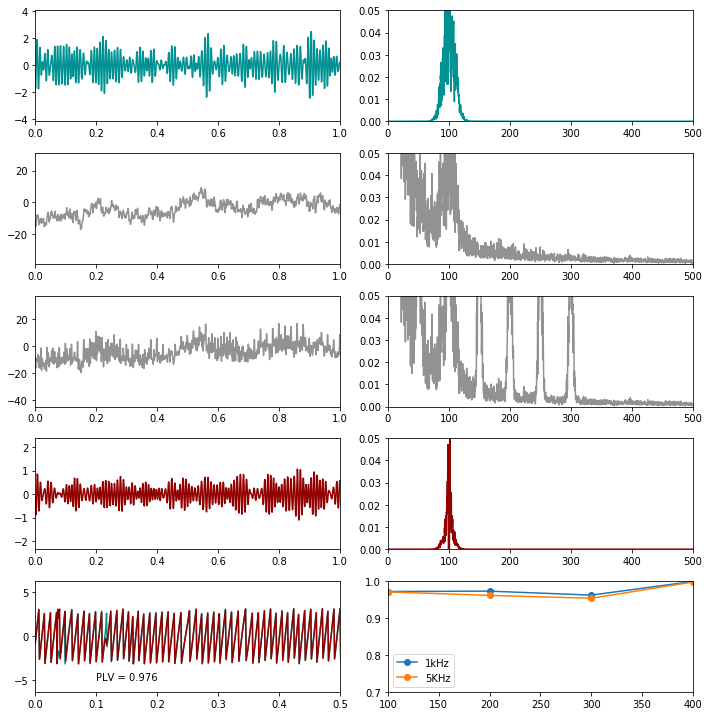

In [83]:
fig, axs = plt.subplots(5,2, figsize=(10,10))
colors = np.array([[0, 146, 146],[146, 146, 146],[146, 146, 146], [146,0,0]])/255

for idx, ax in enumerate(axs[:4]):
    ax[0].plot(t, XX[idx], label='osc', color=colors[idx])
    ax[1].plot(f, (orig_Pxx[idx]), color=colors[idx])
    ax[0].set_xlim([0,1])
    ax[1].set_xlim([0, 500])
    ax[1].set_ylim([0,0.05])
    
axs[-1][0].plot(t, np.angle(x_filt_noise), color=colors[0])
axs[-1][0].plot(t, np.angle(x_filt_orig), color=colors[-1])
axs[-1][0].set_xlim([0,.5])
axs[-1][0].set_ylim([-2*np.pi, 2*np.pi])
axs[-1][0].text(0.1,-5,'PLV = 0.976')

axs[-1][1].plot(np.arange(100,500,100), phase_corr_1, '-o', label='1kHz')
axs[-1][1].plot(np.arange(100,500,100), phase_corr_5, '-o', label='5KHz')
axs[-1][1].set_ylim([0.7, 1])
axs[-1][1].legend()
axs[-1][1].set_xlim([100,400])


fig.tight_layout()
fig.savefig('/home/gabri/line_noise.svg', dpi=300)

4. for the peak (100 Hz for the simulated real 100 Hz signal etc), compute the phase correlation of the filter-recovered signal and original signal generated in (2)

In [29]:
x_filt_noise = filter_data(X_noise, f_c, fs, line_noise=line_noise_fc)
x_filt_orig = filter_data(X, f_c, fs, line_noise=line_noise_fc)
phase_corr = compute_phase_corr(x_filt_noise, x_filt_orig)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.7s finished


In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,5))
ax1.plot(t, np.real(x_filt_noise), label='filt')
ax1.plot(t, np.real(x_filt_orig), label='orig')
ax1.set_xlim([2,3])

ax2.plot(t, np.angle(x_filt_noise))
ax2.plot(t, np.angle(x_filt_orig))
ax2.set_xlim([1,2])
ax2.set_xlabel('Time [s]')


print('PLV:', phase_corr)
fig.tight_layout()
fig.savefig('/home/gabri/line_noise_panel_c.svg',dpi=300)

5. plot the phase correlation for all five frequencies 100, ..., 500

In [16]:
phase_corr_5 = np.zeros((4,))

fs = 5000
t = np.arange(0,25,1/fs)
line_noise_fc = np.arange(50,350,50)
add_noise = generate_one_over_f_noise(sfreq=fs, n=t.shape[0])
noise = np.random.normal(0,1,*t.shape)

for idx, f_c in enumerate(tqdm_notebook(np.arange(100,500,100))):
    # 1. true oscillation
    x1 = simulate_osc_mor(f_c, noise, real=True, fs=fs)

    # 2. oscillation with noise 
    X = x1 + add_noise

    # 3. oscillation with noise+linenoise
    line_noise_harmonics = simulate_line_noise(line_noise_fc, t.shape[0], ampl_scaling=25)
    X_noise = x1 + add_noise + line_noise_harmonics.mean(axis=0)

    # 4. filter-reconstructed activity
    X_filt_noise = filter_data(X_noise, f_c, fs, line_noise=line_noise_fc)
    X_filt_orig = filter_data(X, f_c, fs, line_noise=line_noise_fc)

    phase_corr_5[idx] = compute_phase_corr(X_filt_noise, X_filt_orig)

/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in power


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out

[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.0s finished


In [21]:
phase_corr_1 = np.zeros((4,))

fs = 1000
t = np.arange(0,25,1/fs)
add_noise = generate_one_over_f_noise(sfreq=fs, n=t.shape[0])
line_noise_fc = np.arange(50,350,50)

for idx, f_c in enumerate(tqdm_notebook(np.arange(100,500,100))):
    #1. ground truth oscillation
    noise = np.random.normal(0,1,*t.shape)
    x1 = simulate_osc_mor(f_c, noise, real=True, fs=fs)

    # 2. oscillation with noise 
    X = np.real(x1) + add_noise

    # 3. oscillation with noise+linenoise
    line_noise_harmonics = simulate_line_noise(line_noise_fc, t.shape[0], ampl_scaling=25)
    X_noise = x1 + add_noise + line_noise_harmonics.mean(axis=0)

    # 4. filter-reconstructed activity
    X_filt_noise = filter_data(X_noise, f_c, fs, line_noise=line_noise_fc)
    X_filt_orig = filter_data(X, f_c, fs, line_noise=line_noise_fc)

    phase_corr_1[idx] = compute_phase_corr(X_filt_noise, X_filt_orig)

/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in power


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out

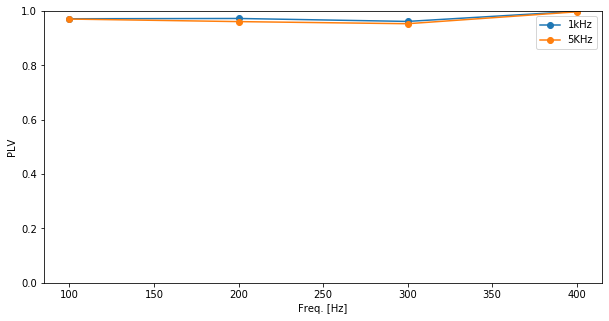

In [22]:
fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(100,500,100), phase_corr_1, '-o', label='1kHz')
plt.plot(np.arange(100,500,100), phase_corr_5, '-o', label='5KHz')
plt.ylim([0,1])
plt.ylabel('PLV')
plt.xlabel('Freq. [Hz]');
plt.legend()
plt.show()




# simulation for phase coupling

1. simulate two oscillatory sources with no-coupling (surrogate level PLV)
2. then add line-noise with model (1) pure-oscillations
3. filter signals in (1) in band and compute PLV between signals (refernece level PLV)
3. compute PLV for signals in (2) and compute PLV 

In [ ]:
fs=5000
f_central=100
T = 1/fs
t = np.arange(0,10,T)

noise = np.random.normal(0,1,*t.shape)

s1 = simulate_osc_mor(100, noise, real=True, fs= fs)
s2 = np.roll(s1,np.random.randint(np.round(s1.shape[0]/3),s1.shape[0]))

add_noise = generate_one_over_f_noise(sfreq=fs, n=s1.shape[0])
s1_true = filter_data(s1 + add_noise, f_central, fs, line_noise=np.empty((0,)))
s2_true = filter_data(s2 + add_noise, f_central, fs, line_noise=np.empty((0,)))

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
ax1.plot(t, np.real(s1_true))
ax2.plot(t, np.real(s2_true))

ax1.set_xlim([1,2])
ax2.set_xlim([1,2])

print(compute_phase_corr(s1_true, s2_true))

In [ ]:
line_noise_array = np.arange(50,350,50)

line_noise = simulate_line_noise(line_noise_array, s1.shape[0])

s1_noise = s1 + add_noise + line_noise.sum(axis=0)
s2_noise = s2 + add_noise + line_noise.sum(axis=0)

s1_filt = filter_data(s1_noise,f_central, fs, line_noise=line_noise_array)
s2_filt = filter_data(s2_noise,f_central, fs, line_noise=line_noise_array)

print(compute_phase_corr(s1_filt, s2_filt))

In [ ]:
fs=5000
f_central=100
T = 1/fs
t = np.arange(0,5,T)
n_run = 10

line_noise_array = np.arange(50,350,50)
plv_out = np.zeros((n_run,2))

add_noise = generate_one_over_f_noise(sfreq=fs, n=t.shape[0])
# add_noise = np.random.normal(0, 1, *t.shape)
# line_noise = simulate_line_noise(line_noise_array, t.shape[0])
line_noise = line_noise_triangle(line_noise, fs, n_samples=X.shape[0])

ch_names = ['ch1','ch2']
ch_types = ['eeg','eeg']
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)

for sim_idx in tqdm_notebook(range(n_run)):

    noise = np.random.normal(0, 1, *t.shape)

    s1 = simulate_osc_mor(100, noise, real=True, fs= fs)+add_noise
    s2 = np.roll(s1, np.random.randint(np.round(s1.shape[0]/3),s1.shape[0]))

    s1_true = filter_data(s1, f_central, fs, line_noise=np.empty((0,)))
    s2_true = filter_data(s2, f_central, fs, line_noise=np.empty((0,)))

    s1_noise = s1 + add_noise + line_noise.sum(axis=0)
    s2_noise = s2 + add_noise + line_noise.sum(axis=0)
    
    s_noise_raw = mne.io.RawArray(np.stack((s1_noise,s2_noise)), info)    
    s_noise_raw.notch_filter(line_noise_array,filter_length=8001, trans_bandwidth=5)

    s1_filt = filter_data(s_noise_raw.get_data()[0], f_central, fs, line_noise=np.empty((0,)))
    s2_filt = filter_data(s_noise_raw.get_data()[1], f_central, fs, line_noise=np.empty((0,)))
    
    plv_out[sim_idx, 0] = compute_phase_corr(s1_true, s2_true)
    plv_out[sim_idx, 1] = compute_phase_corr(s1_filt, s2_filt)
    

In [ ]:
ax = sns.boxplot(data=plv_out)
sns.swarmplot(data=plv_out)
plt.xticks(range(2), ('observed','line-noise'))
plt.ylabel('PLV');

In [ ]:
ranksums(plv_out[:,0],plv_out[:,1])

In [ ]:
data = np.stack((s1_noise, s2_noise))
info = mne.create_info(ch_names=['ch1','ch2'], sfreq=fs, ch_types=['eeg','eeg'])

raw = mne.io.RawArray(data, info)

In [ ]:
raw.notch_filter(line_noise_array, trans_bandwidth=2)

In [ ]:
raw.plot_psd(fmax=400, spatial_colors=False);

In [ ]:
s_noise_raw.get_data()[1].shape

In [39]:
def worker(add_noise, line_noise, info, line_noise_array):
    noise = np.random.normal(0,1,*add_noise.shape)
    #1. ground truth oscillation
    s1 = simulate_osc_mor(f_c, noise, real=True, fs=fs)
    s2 = np.roll(s1,np.random.randint(np.round(s1.shape[0]/3),s1.shape[0]))
    
    # 2. oscillation with noise 
    s1_orig = s1 + add_noise
    s2_orig = s2 + add_noise

    # 3. oscillation with noise+linenoise
    s1_noise = s1 + add_noise + line_noise_harmonics.mean(axis=0)
    s2_noise = s2 + add_noise + line_noise_harmonics.mean(axis=0)

    # 4. filter-reconstructed activity
    s1_filt_noise = filter_data(s1_noise, f_c, fs, line_noise=line_noise_fc)
    s2_filt_noise = filter_data(s2_noise, f_c, fs, line_noise=line_noise_fc)
    
    s1_filt_orig = filter_data(s1_orig, f_c, fs, line_noise=line_noise_fc)
    s2_filt_orig = filter_data(s2_orig, f_c, fs, line_noise=line_noise_fc)
   
    return compute_phase_corr(s1_filt_orig, s2_filt_orig), compute_phase_corr(s1_filt_noise, s2_filt_noise)

fs=5000
f_central=100
T = 1/fs
t = np.arange(0,25,T)
n_run = 100

line_noise_array = np.arange(50,350,50)
plv_out =np.zeros((n_run,2))

add_noise = generate_one_over_f_noise(sfreq=fs, n=t.shape[0])
# add_noise = np.random.normal(0, 1, *t.shape)
# line_noise = simulate_line_noise(line_noise_array, t.shape[0])

line_noise_harmonics = simulate_line_noise(line_noise_fc, t.shape[0], ampl_scaling=25)

ch_names = ['ch1','ch2']
ch_types = ['eeg','eeg']
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types=ch_types)

plv_out = Parallel(n_jobs=32, verbose=5)(
         delayed(worker)(add_noise, line_noise_harmonics, info, line_noise_array) for r_idx in range(n_run))

plv_out = np.array(plv_out)

/home/gabri/.conda/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in power
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:  7.7min
[Parallel(n_jobs=32)]: Done  58 out of 100 | elapsed: 15.7min remaining: 11.4min
[Parallel(n_jobs=32)]: Done  79 out of 100 | elapsed: 23.3min remaining:  6.2min
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed: 28.1min remaining:    0.0s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed: 28.1min finished


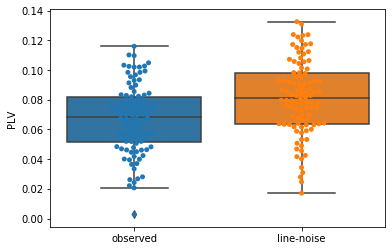

In [40]:
ax = sns.boxplot(data=plv_out)
sns.swarmplot(data=plv_out)
plt.xticks(range(2), ('observed','line-noise'))
plt.ylabel('PLV');

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(t, s1_noise)
plt.xlim([1,1.1])